# Secretory Reactions
Here we will map all the secretory reactions from the [Mammalian Secretory Pathway Reconstruction paper](https://www.nature.com/articles/s41467-019-13867-y) to the genes in our reconstruction.

1. Load Secretory Pathway Reactions

In [1]:
import datetime

import re
import pandas as pd
import numpy as np
from google_sheet import GoogleSheet
from collections import defaultdict

import matplotlib.pyplot as plt
from venn import venn

In [2]:
##### ----- Generate datasets from Google Sheet ----- #####

#Credential file
KEY_FILE_PATH = 'credentials.json'

#CHO Network Reconstruction + Recon3D_v3 Google Sheet ID
Sec_Recon_SPREADSHEET_ID = '1DaAdZlvMYDqb7g31I5dw-ZCZH52Xj_W3FnQMFUzqmiQ'

# Initialize the GoogleSheet object
sec_recon_gsheet_file = GoogleSheet(Sec_Recon_SPREADSHEET_ID, KEY_FILE_PATH)

# Read data from SecRecon
sec_genes_sheet = 'SecRecon'
sec_genes = sec_recon_gsheet_file.read_google_sheet(sec_genes_sheet)

In [3]:
# Load the rest of the recons
Feizi = pd.read_excel('Input/Feizi_secRecon.xlsx', skiprows=4)
Lund = pd.read_excel('Input/Lund_secRecon.xlsx')
Lund['CHO_GeneID'] = Lund['CHO_GeneID'].astype(str).str.replace(r'\.0$', '', regex=True)
Jahir = pd.read_excel('Input/Jahir_secRecon.xlsx', sheet_name="Components (Human)")

/Users/pablodigiusto/miniforge3/envs/secrecon2.0/lib/python3.11/site-packages/openpyxl/worksheet/_read_only.py:81: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [4]:
# Create a  mapping dicts

choentrez_humanentrez = {row['CHO ENTREZID']: row['HUMAN ENTREZID'] for _, row in sec_genes.dropna(subset=['CHO ENTREZID', 'HUMAN ENTREZID']).iterrows()}

humanens_humanentrez = {}
for _, row in sec_genes.dropna(subset=['HUMAN ENSEMBL', 'HUMAN ENTREZID']).iterrows():
    ensembl_ids = row['HUMAN ENSEMBL'].split(',')
    entrez_id = row['HUMAN ENTREZID']
    
    for ensembl_id in ensembl_ids:
        humanens_humanentrez[ensembl_id] = entrez_id

In [5]:
Feizi_humanentrez_list = []
for i,row in Feizi.iterrows():
    human_ensmbl = row['ensgid']
    if human_ensmbl in humanens_humanentrez.keys():
        Feizi_humanentrez_list.append(humanens_humanentrez[human_ensmbl])
    else:
        Feizi_humanentrez_list.append(human_ensmbl)

print(len(Feizi_humanentrez_list))

575


In [6]:
Lund_humanentrez_list = []
for i,row in Lund.iterrows():
    cho_entrez = row['CHO_GeneID']
    if cho_entrez in choentrez_humanentrez.keys():
        Lund_humanentrez_list.append(choentrez_humanentrez[cho_entrez])
    else:
        Lund_humanentrez_list.append(cho_entrez)

print(len(Lund_humanentrez_list))

807


In [7]:
Jahir_gene_list = Jahir['GeneID'].astype(str).tolist()

print(len(Jahir_gene_list))

271


In [8]:
sec_recon_list = list(sec_genes['HUMAN ENTREZID'])

print(len(sec_recon_list))

1127


In [9]:
# Create sets from lists
sec_recon_set = set(sec_recon_list)
Lund_gene_set = set(Lund_humanentrez_list)
Jahir_gene_set = set(Jahir_gene_list)
Feizi_gene_set = set(Feizi_humanentrez_list)

<Figure size 1000x1000 with 0 Axes>

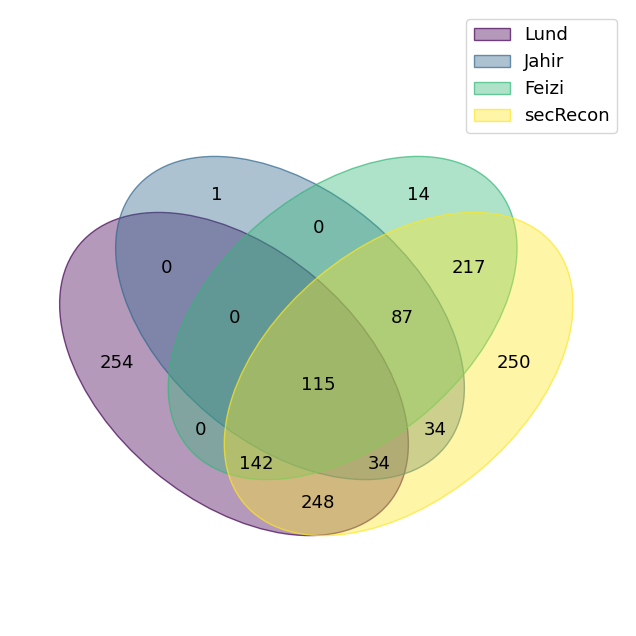

In [10]:
# Create a dictionary for the Venn diagram
venn_dict = {
    'Lund': Lund_gene_set,
    'Jahir': Jahir_gene_set,
    'Feizi': Feizi_gene_set,
    'secRecon': sec_recon_set
}

# Plot the Venn diagram
plt.figure(figsize=(10, 10))
venn(venn_dict)
plt.savefig('Plots/venn_diagram.png', dpi=300)
plt.show()

In [ ]:
sec_recon_set